Karina Chiñas Fuenes | 18/04/2023 | Universiteit Gent

In [1]:
%load_ext autoreload
%autoreload 2

This notebook is based on the document:

* _Feature Selection for Clustering_, [Manoranjan Dash and Huan Liu](https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf), 2000.

# NON-RESEARCH VARIABLES

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

import FeatureSelectTK as fs

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_columns', None)
path = "../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
#min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

40.69% of the data decreased alpha_R
59.31% of the data did not decrease alpha_R


## Treatment to Categorical Data

In [4]:
TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE","ECHMODE",
               "ICSCHEME","AUXHEAT","EVAP","PELLET"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

# Removing noise on heating scheme | the removed coluns are shots from 1996
DB5 = DB5[~DB5["AUXHEAT"].isin(["UNKNOWN"])]

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)

DB5["PELLET"] = DB5["PELLET"].str.replace("GP_D","D",regex=False)
DB5["PELLET"] = DB5["PELLET"].str.replace("GP_H","H",regex=False)

## Treatment to Numerical Data

In [5]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"
                         ] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI"]
 # corrections on power loss | NBI Power lost by unconfined orbits
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
# e-density in SOL | total due to NBI| total due to ICRH
fast_particles = ["NESOL","WFFORM","WFICFORM"] 
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

interesting_features = set(plasma_characteristics + TOK_characteristics + ELM + heating + \
                       impurities + power  + fast_particles)

data = DB5.copy()
data = data[list(interesting_features)]

num_features = data.select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()


def impute_with_median(series):
    return series.fillna(series.median())

for tokamak in data["TOK"].unique():
    indx_tok = data[data['TOK'] == tokamak].index
    data.loc[indx_tok, num_features] = data[num_features].apply(impute_with_median)

data[num_features] = StandardScaler().fit_transform(data[num_features])

In [6]:
N,M = data.shape

# used to get feature ranking
feature_dic = dict( zip( list(range(M)), data.columns ) )

## ENTROPY IN DATASET | Categorical
#### Using the concept of entropy to rank the importance of features.

0. Computing the distance between two points

Euclidean distance:

$$
    D^k_{ij} = \left( \frac{ x_{ik} - x_{jk} }{ max(F_k) - min(F_k) } \right)^2 
$$

$$
    D_{ij} = \left[ \sum^M_{k=1} \: D^k_{ij}\right]^{1/2}
$$

Where $F_k$ is the $k$-th column representing the $k$-th feature. With $k=1,\dots,M$ The $x_{ik}$ is the $i$-th point of the $k$-th feature; the same for $j$. With $i$,$j=1\ldots,N$. And $N$ being the total points of observations. Thus the similarity between two points

Defined as:

$$
    S_{ij} = e^{-\alpha \cdot D_{ij}}
$$

Where $\alpha$ is a parameter. Here $\alpha = 0.5$. According to [Manoranjan Dash and Huan Liu](https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf), If one plots similarity vs distance, the curve will have a biggercurvature for a larger $\alpha$. 

1. Computing the similarity between two points with Humming distance:

\begin{equation}
        S_{ij} = \frac{1}{M}\sum^M_{k=1} \delta_{ij}(x^k); \quad \text{with} \:\: \delta_{ij}(x^k) = \begin{cases}
    1,\:\text{if}\:\: x^k_i = x^k_j\\
    0,\:\text{if}\:\: x^k_i \neq x^k_j
    \end{cases}
\end{equation}

With $M$ being the total number of features.


2. The entropy of the dataset is:

$$
    E = -\sum^N_{i=1}\sum^N_{j=1} E_{ij}= -\sum^N_{i=1}\sum^N_{j=1}\left[ S_{ij}\cdot\text{Log}\left(S_{ij}\right) +  \left(1-S_{ij}\right)\cdot\text{Log}\left(1-S_{ij}\right) \right]
$$

In the expression above, $N$ corresponds to the total number of observations in dataset (rows). 

The ranking is done in an interative process: eliminate a column at a time and assess the disorder that the removal has caused by calculating the corresponding entropy. Let us sat that $E_{^-F_i} > E_{^-F_j}$ is the statement that the removal of feature $i$ of the dataset caused more disorder than the removal of feature $j$. One can then construct an array $\vec{E_-} = \{E_{F_k}\}$, for $k=1,\ldots,M$. Thus, the most important feature will be  max$(\vec{E_-})$.

$\delta_{ij}(x^k)\:\rightarrow$ `np.frompyfunc( lambda x,y: x-y, 2, 1).reduce( np.array( np.meshgrid(F_k,F_k) ) )`

In [7]:
features_ranked_entropy = fs.get_ranked_features(data)
ordered_features = list(features_ranked_entropy.index.map(feature_dic))

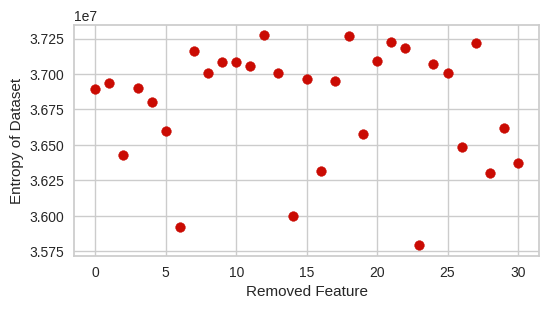

In [8]:
plt.figure(figsize=(6,3))
plt.scatter(features_ranked_entropy.index, features_ranked_entropy.values, c="r")
plt.xlabel("Removed Feature")
plt.ylabel("Entropy of Dataset");

In [9]:
print(ordered_features,)

['ZEFFNEO', 'WFICFORM', 'DWDIA', 'WFFORM', 'POHM', 'ELMFREQ', 'DIVNAME', 'ZEFF', 'TOK', 'TORQ', 'PFLOSS', 'QCYL5', 'PICRH', 'WALMAT', 'PECRH', 'BEIMHD', 'WMHD', 'PRAD', 'NESOL', 'PLTH', 'PREMAG', 'ENBI', 'EVAP', 'LIMMAT', 'DIVMAT', 'HYBRID', 'ELMTYPE', 'LHTIME', 'ICSCHEME', 'CONFIG', 'AUXHEAT']
